# Feature Selection
created by: Pat Pascual

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency


In [3]:
# Read the dataset
df = pd.read_csv('dataset.csv', sep='|')

In [4]:
# Drop duplicate rows and store in new dataframe
df = df.drop_duplicates()

# Print number of rows removed
print(f"Number of rows after removing duplicates: {len(df)}")

Number of rows after removing duplicates: 34989


In [5]:
df.shape

(34989, 21)

In [6]:
df.nunique()


Feature_ae_0       77
Feature_dn_1     1488
Feature_cn_2       39
Feature_ps_3       26
Feature_ps_4        8
Feature_ee_5       10
Feature_cx_6       26
Feature_cx_7       26
Feature_em_8      314
Feature_nd_9       11
Feature_jd_10      12
Feature_md_11       4
Feature_ed_12       8
Feature_dd_13       3
Feature_hd_14       3
Feature_ld_15       3
Feature_cd_16       2
Feature_md_17      10
Feature_dd_18       5
Feature_pd_19       3
Response            2
dtype: int64

In [7]:
# Separate numerical and categorical columns
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Correlation Analysis for Numerical Features

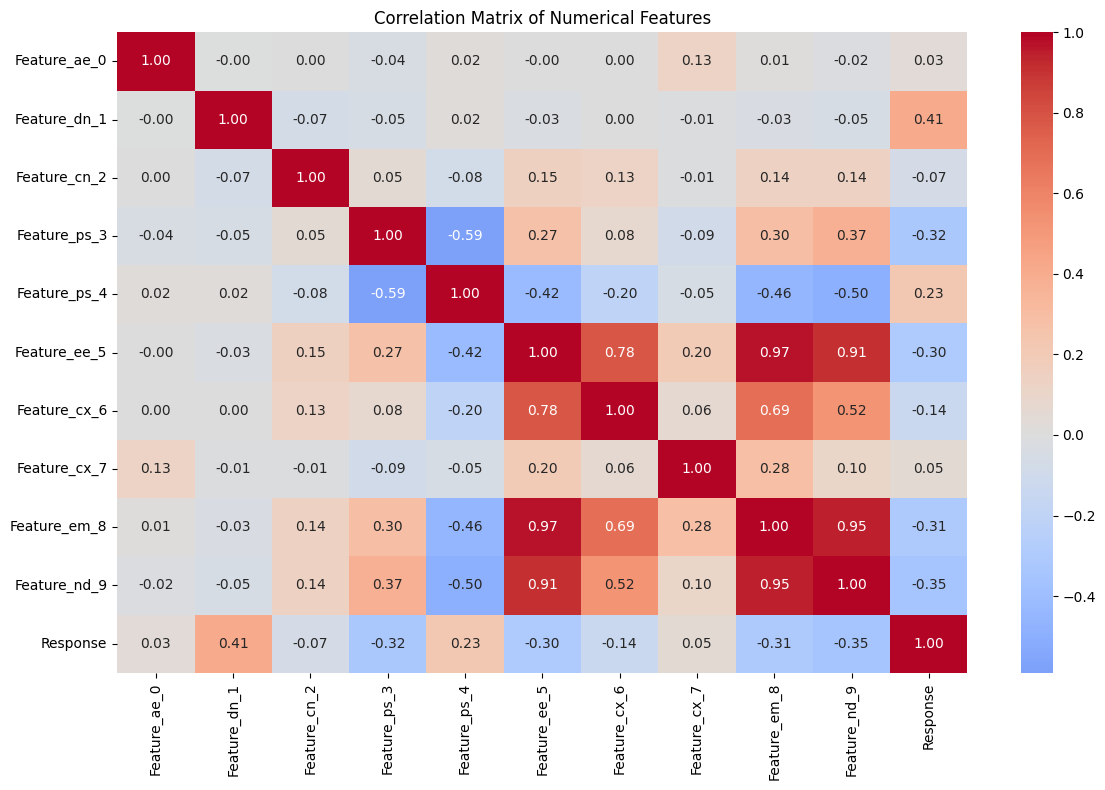

In [8]:
# Create correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [9]:
# Find highly correlated pairs (above 0.7)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i,j]) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i,j]
            ))

print("\nHighly correlated feature pairs (|correlation| > 0.7):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"{feat1} - {feat2}: {corr:.3f}")


Highly correlated feature pairs (|correlation| > 0.7):
Feature_ee_5 - Feature_cx_6: 0.776
Feature_ee_5 - Feature_em_8: 0.972
Feature_ee_5 - Feature_nd_9: 0.907
Feature_em_8 - Feature_nd_9: 0.945


# Analysis of Numerical Feature Correlations

The correlation analysis reveals several strong relationships between macroeconomic variables:

1. Employment variation rate (Feature_ee_5) shows strong positive correlations with:
   - Consumer price index (Feature_cx_6): 0.776
   - 3-month interbank rate (Feature_em_8): 0.972 
   - Number of employees (Feature_nd_9): 0.907

2. 3-month interbank rate (Feature_em_8) and number of employees (Feature_nd_9) are also highly correlated (0.945)

These high correlations between macro variables suggest potential multicollinearity issues that should be addressed in modeling. We may need to:
- Select only one representative variable from highly correlated pairs
- Use dimensionality reduction techniques 
- Consider creating composite features

# Correlation Threshold Selection

The threshold of 0.7 for identifying highly correlated features is a commonly used rule of thumb in statistics and machine learning, established through empirical research and practical experience:

- Cohen (1988) proposed correlation coefficient interpretations:
  - 0.1-0.3: Small correlation
  - 0.3-0.5: Medium correlation  
  - >0.5: Large correlation
- Dormann et al. (2013) found that correlations >0.7 significantly impact model stability
- Correlations >0.7 indicate strong relationships that can cause multicollinearity issues:
  - Make model coefficients unstable and difficult to interpret
  - Increase variance of coefficient estimates
  - Lead to overfitting

# Outlier Analysis for Numerical Features

In [10]:
# Outlier Analysis for Numerical Features
def plot_boxplots(df, features, ncols=3):
    nrows = (len(features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features):
        sns.boxplot(data=df, y=feature, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {feature}')
    
    # Hide empty subplots
    for idx in range(len(features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

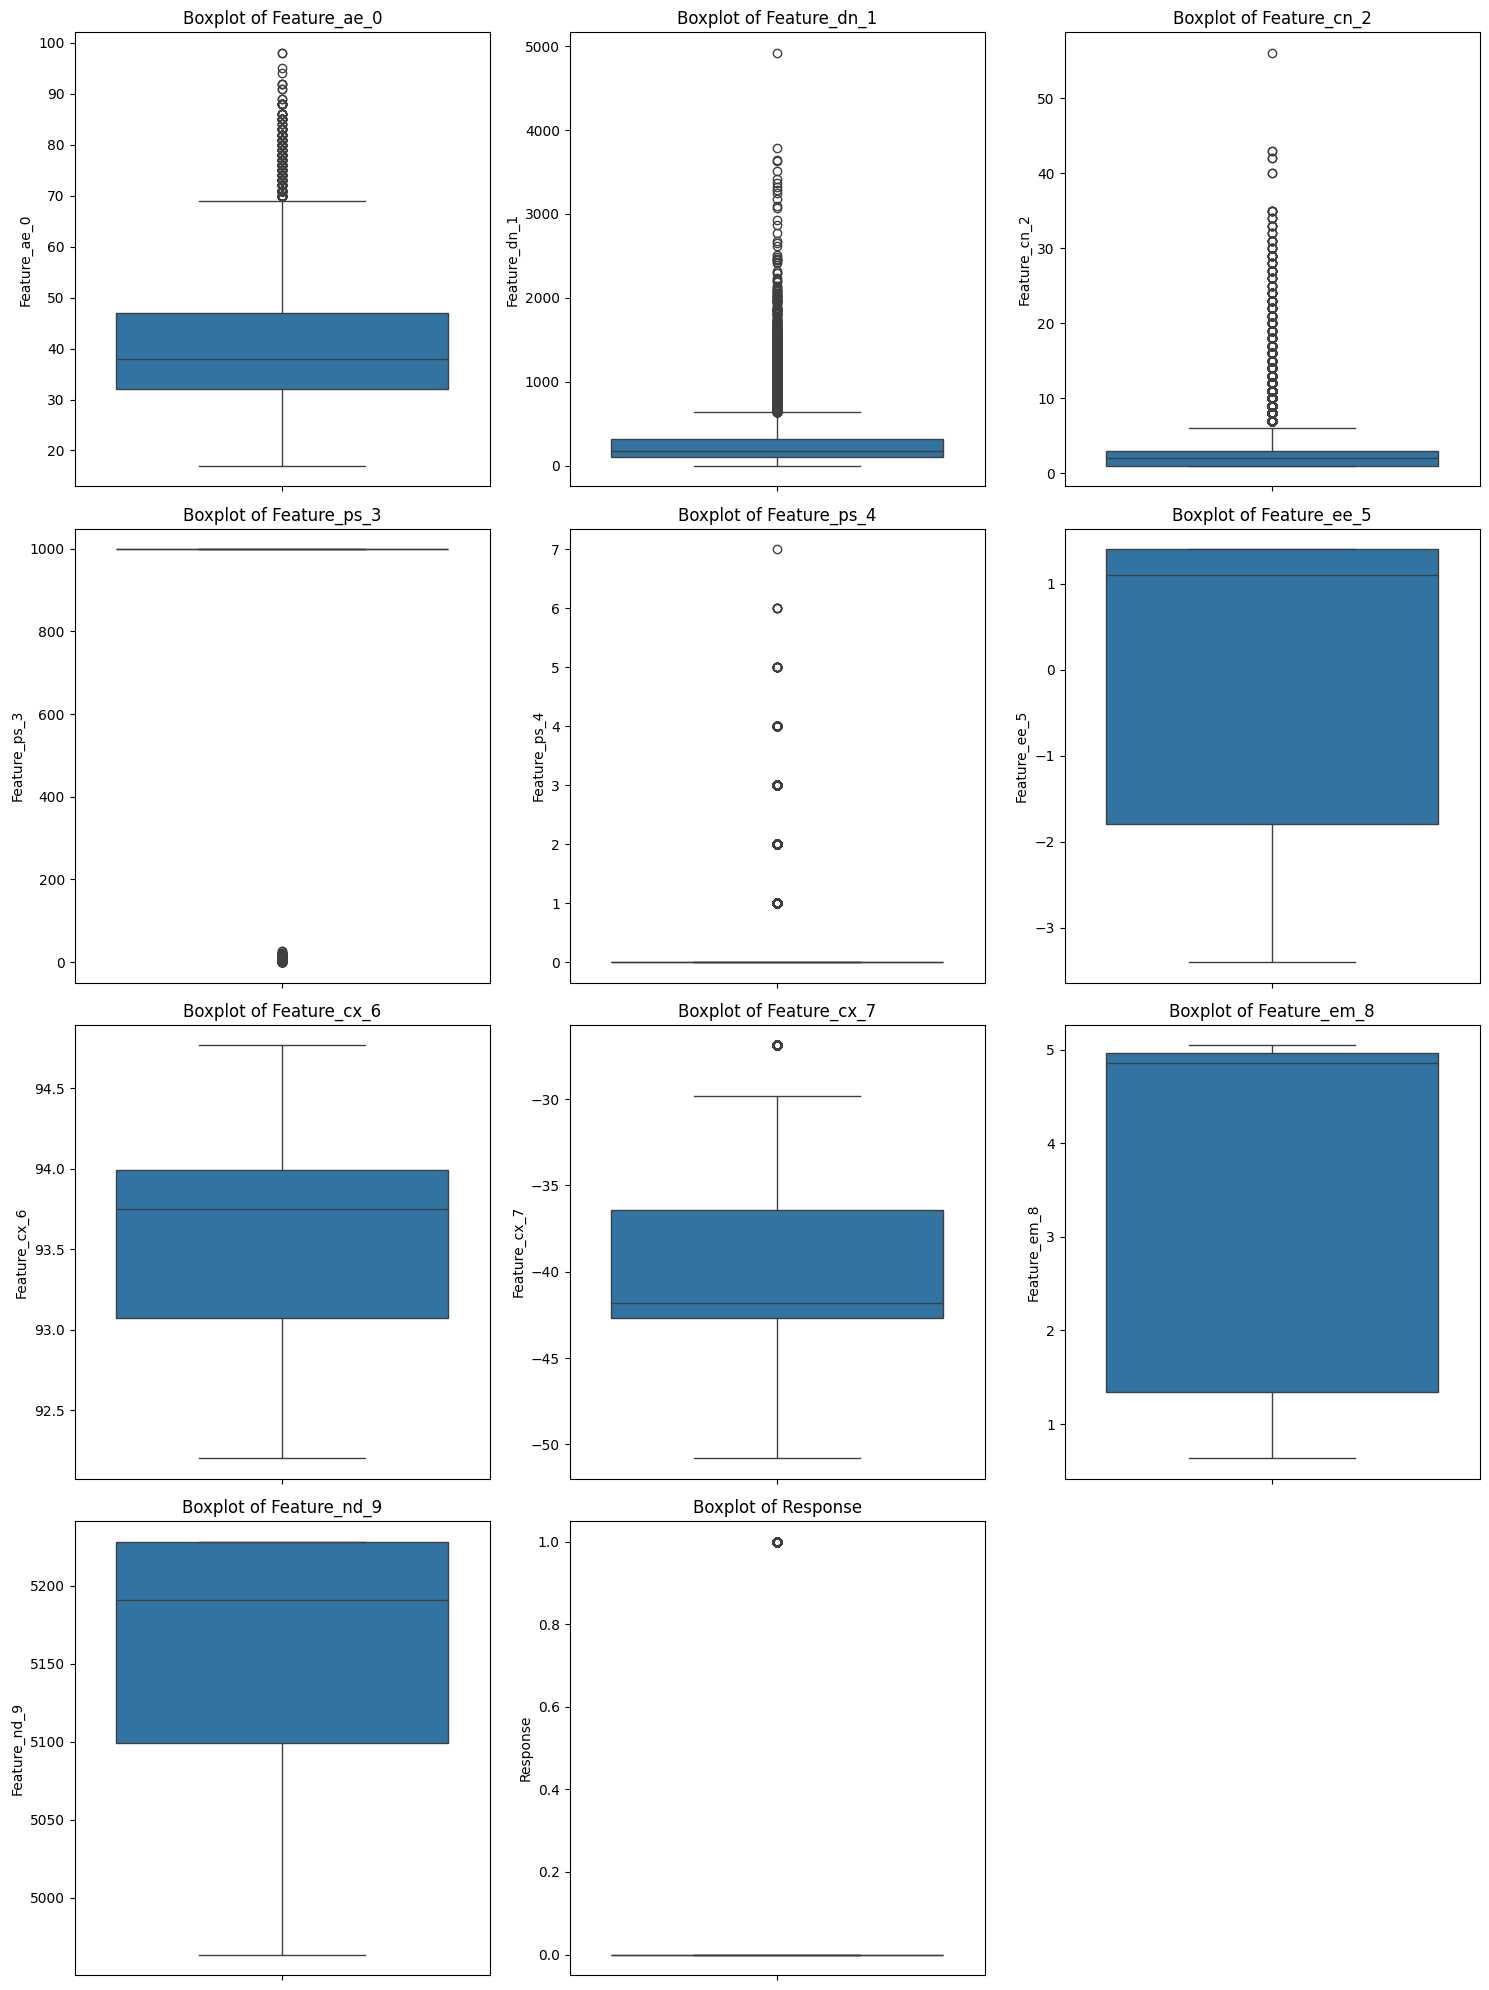

In [11]:
# Plot boxplots for numerical features
plot_boxplots(df, numerical_features)

In [12]:
# Calculate outlier statistics
def get_outlier_stats(df, features):
    stats = {}
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        
        stats[feature] = {
            'outliers_count': len(outliers),
            'outliers_percentage': (len(outliers) / len(df)) * 100,
            'min': df[feature].min(),
            'max': df[feature].max(),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
    return stats

outlier_stats = get_outlier_stats(df, numerical_features)

In [13]:
# Print outlier summary
print("Outlier Summary:")
for feature, stats in outlier_stats.items():
    print(f"\n{feature}:")
    print(f"Number of outliers: {stats['outliers_count']} ({stats['outliers_percentage']:.2f}%)")
    print(f"Range: [{stats['min']:.2f}, {stats['max']:.2f}]")
    print(f"Expected range: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")


Outlier Summary:

Feature_ae_0:
Number of outliers: 401 (1.15%)
Range: [17.00, 98.00]
Expected range: [9.50, 69.50]

Feature_dn_1:
Number of outliers: 2534 (7.24%)
Range: [0.00, 4918.00]
Expected range: [-222.00, 642.00]

Feature_cn_2:
Number of outliers: 2036 (5.82%)
Range: [1.00, 56.00]
Expected range: [-2.00, 6.00]

Feature_ps_3:
Number of outliers: 1289 (3.68%)
Range: [0.00, 999.00]
Expected range: [999.00, 999.00]

Feature_ps_4:
Number of outliers: 4808 (13.74%)
Range: [0.00, 7.00]
Expected range: [0.00, 0.00]

Feature_ee_5:
Number of outliers: 0 (0.00%)
Range: [-3.40, 1.40]
Expected range: [-6.60, 6.20]

Feature_cx_6:
Number of outliers: 0 (0.00%)
Range: [92.20, 94.77]
Expected range: [91.70, 95.37]

Feature_cx_7:
Number of outliers: 375 (1.07%)
Range: [-50.80, -26.90]
Expected range: [-52.15, -26.95]

Feature_em_8:
Number of outliers: 0 (0.00%)
Range: [0.63, 5.04]
Expected range: [-4.08, 10.39]

Feature_nd_9:
Number of outliers: 0 (0.00%)
Range: [4963.60, 5228.10]
Expected range

# Outlier Analysis Summary

Based on the outlier analysis:

1. Features with concerning outlier percentages (>5%):
- Feature_ps_4: 13.74% outliers
- Feature_dn_1: 7.24% outliers  
- Feature_cn_2: 5.82% outliers

2. Features with moderate outlier percentages (1-5%):
- Feature_ps_3: 3.68% outliers
- Feature_ae_0: 1.15% outliers
- Feature_cx_7: 1.07% outliers

3. Features with no outliers:
- Feature_ee_5
- Feature_cx_6  
- Feature_em_8
- Feature_nd_9

Given that we have 34,989 rows, features with >5% outliers (>1,750 rows) should be carefully examined as they may indicate underlying data quality issues or require special treatment. The other features have acceptable outlier levels that can be handled through standard techniques.


In [25]:
# Check number of unique values for features with high outlier percentages
high_outlier_features = ['Feature_ps_4', 'Feature_dn_1', 'Feature_cn_2']

print("Number of unique values in features with high outliers:")
for feature in high_outlier_features:
    print(f"{feature}: {df[feature].nunique()} unique values")



Number of unique values in features with high outliers:
Feature_ps_4: 8 unique values
Feature_dn_1: 1488 unique values
Feature_cn_2: 39 unique values


# Categorical Variables Analysis

In [14]:
# 1. Categorical Correlation (Cramer's V)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

In [15]:
# Calculate Cramer's V correlation matrix for categorical variables
cat_correlation_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)
for i in categorical_features:
    for j in categorical_features:
        cat_correlation_matrix.loc[i,j] = cramers_v(df[i], df[j])

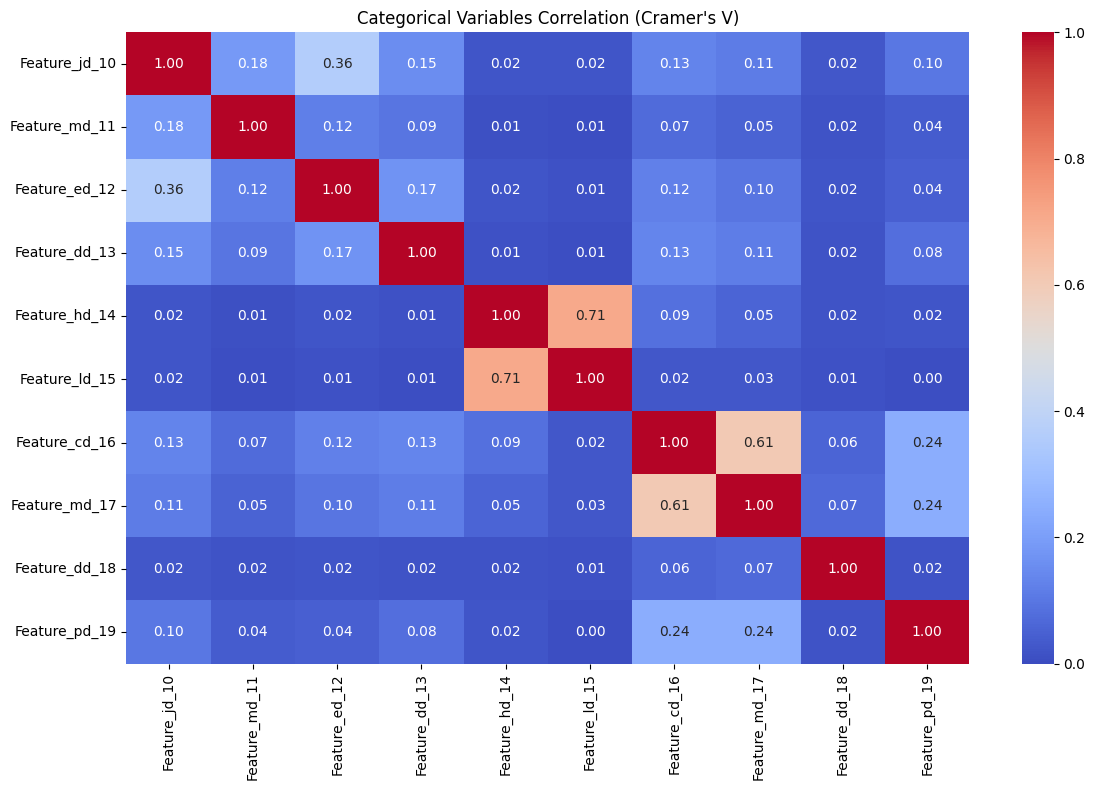

In [16]:
# Plot categorical correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cat_correlation_matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt='.2f')
plt.title("Categorical Variables Correlation (Cramer's V)")
plt.tight_layout()
plt.show()

## Interpretation of Cramer's V Correlation Analysis
### Key Findings by Correlation Strength

#### Strong Correlations (V > 0.6)
- Contact medium (Feature_cd_16) and Month contacted (Feature_md_17)
  - Strong association (V = 0.61)
  - Suggests potential redundancy in capturing contact timing information

#### Moderate Correlations (0.3 < V < 0.6) 
- No moderate correlations observed between categorical variables
- Indicates good feature independence in mid-range

#### Weak Correlations (V < 0.3)
Most feature pairs show weak correlation


### Overall Assessment
- Minimal redundancy in categorical feature set
- Most features capture distinct aspects of the data
- Only one strong correlation pair identified
- Suggests good feature independence for modeling purposes


# Predictive Power Analysis

## Weight of Evidence (WOE) and Information Value (IV)

Analyzing Numerical Features...


C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


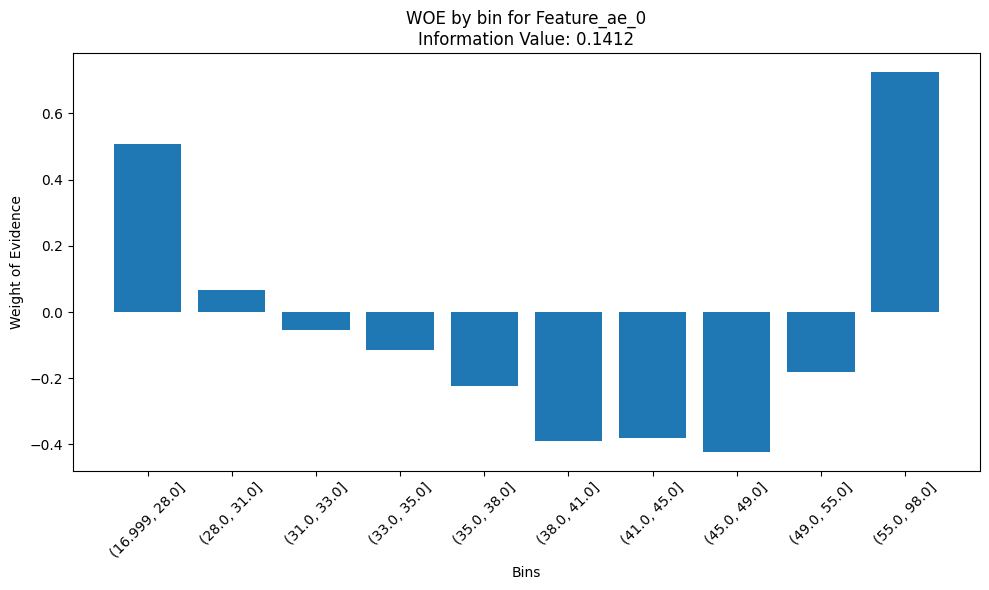


Feature: Feature_ae_0
Information Value: 0.1412

Detailed Statistics:
                total  good   bad  good_pct   bad_pct       woe  iv_component
bins                                                                         
(16.999, 28.0]   3591   624  2967  0.158819  0.095525  0.508380      0.032178
(28.0, 31.0]     4352   518  3834  0.131840  0.123439  0.065847      0.000553
(31.0, 33.0]     3092   331  2761  0.084245  0.088892 -0.053694      0.000250
(33.0, 35.0]     3012   305  2707  0.077628  0.087154 -0.115749      0.001103
(35.0, 38.0]     3929   361  3568  0.091881  0.114874 -0.223347      0.005136
(38.0, 41.0]     3295   260  3035  0.066175  0.097714 -0.389749      0.012292
(41.0, 45.0]     3641   290  3351  0.073810  0.107888 -0.379597      0.012936
(45.0, 49.0]     3211   246  2965  0.062611  0.095460 -0.421765      0.013855
(49.0, 55.0]     3831   366  3465  0.093153  0.111558 -0.180299      0.003318
(55.0, 98.0]     3035   628  2407  0.159837  0.077495  0.723940      0.

C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


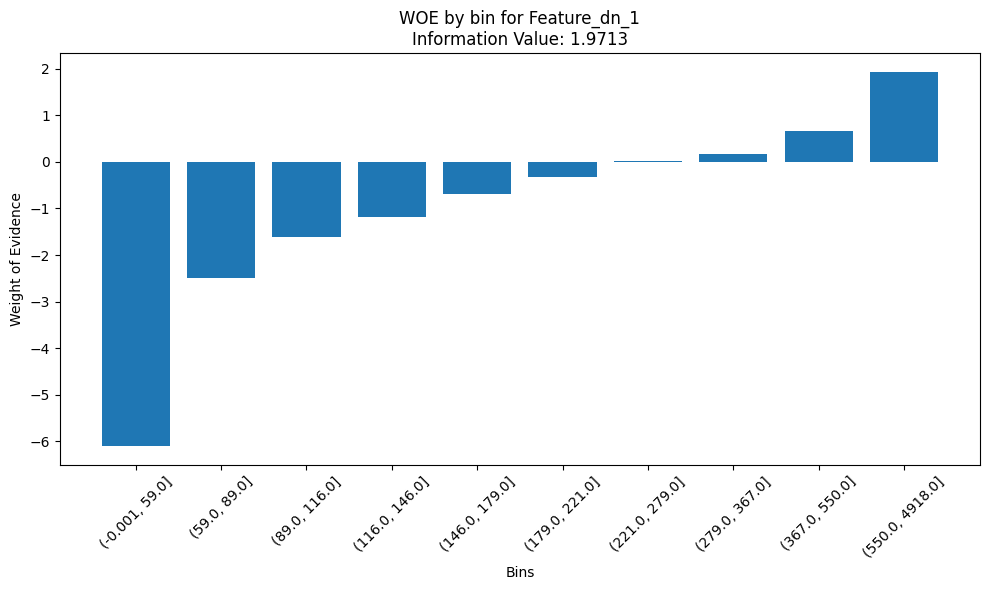


Feature: Feature_dn_1
Information Value: 1.9713

Detailed Statistics:
                 total  good   bad  good_pct   bad_pct       woe  iv_component
bins                                                                          
(-0.001, 59.0]    3542     1  3541  0.000255  0.114005 -6.104629      0.694405
(59.0, 89.0]      3579    37  3542  0.009417  0.114037 -2.493993      0.260922
(89.0, 116.0]     3384    83  3301  0.021125  0.106278 -1.615604      0.137574
(116.0, 146.0]    3533   133  3400  0.033851  0.109466 -1.173646      0.088745
(146.0, 179.0]    3477   209  3268  0.053194  0.105216 -0.682063      0.035482
(179.0, 221.0]    3499   291  3208  0.074065  0.103284 -0.332544      0.009717
(221.0, 279.0]    3486   401  3085  0.102062  0.099324  0.027190      0.000074
(279.0, 367.0]    3508   454  3054  0.115551  0.098326  0.161426      0.002781
(367.0, 550.0]    3488   693  2795  0.176381  0.089987  0.672978      0.058141
(550.0, 4918.0]   3493  1627  1866  0.414100  0.060077  1.93

C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


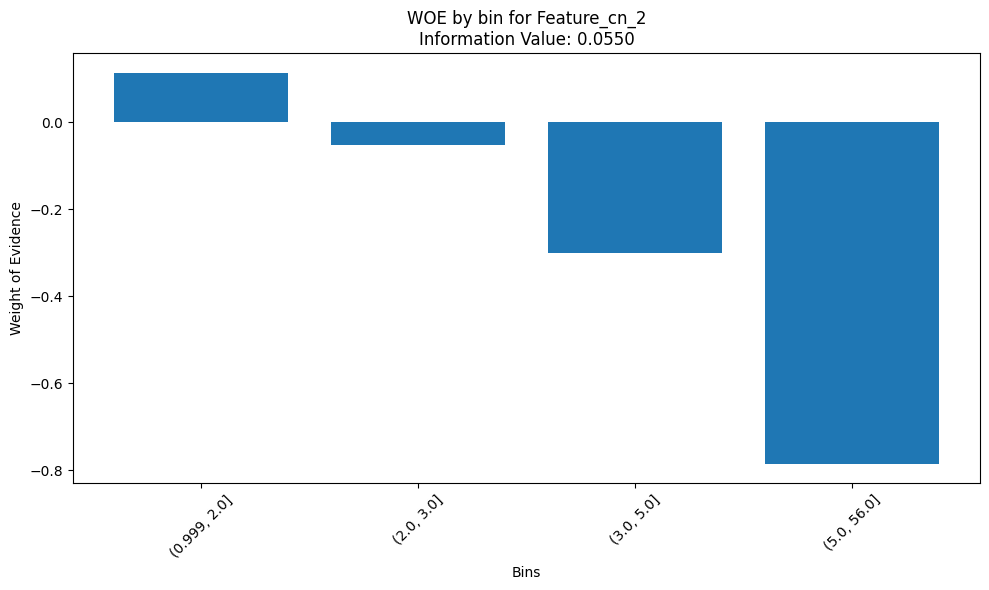


Feature: Feature_cn_2
Information Value: 0.0550

Detailed Statistics:
              total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                        
(0.999, 2.0]  24000  2979  21021  0.758208  0.676787  0.113602      0.009250
(2.0, 3.0]     4533   486   4047  0.123696  0.130296 -0.051987      0.000343
(3.0, 5.0]     3597   308   3289  0.078391  0.105892 -0.300703      0.008269
(5.0, 56.0]    2859   156   2703  0.039705  0.087025 -0.784726      0.037133




C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


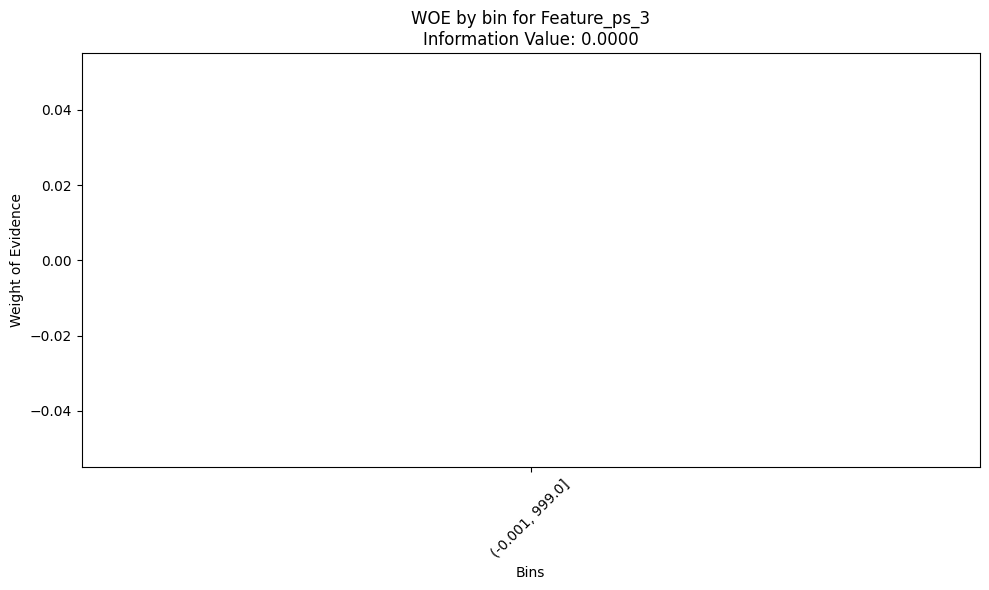


Feature: Feature_ps_3
Information Value: 0.0000

Detailed Statistics:
                 total  good    bad  good_pct  bad_pct  woe  iv_component
bins                                                                     
(-0.001, 999.0]  34989  3929  31060       1.0      1.0  0.0           0.0




C:\Users\RonaldPatrickPascual\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


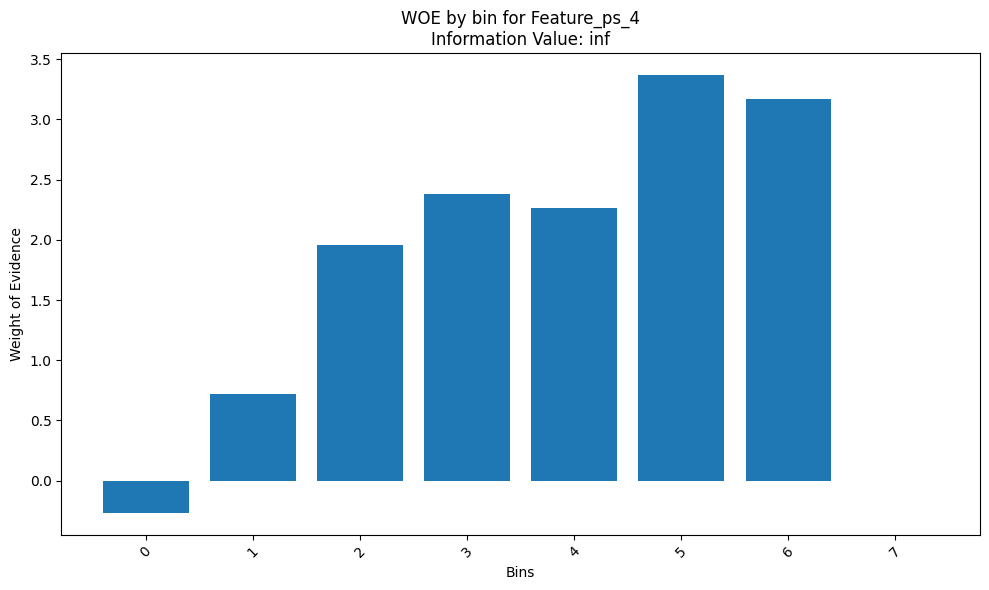


Feature: Feature_ps_4
Information Value: inf

Detailed Statistics:
      total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                
0     30181  2668  27513  0.679053  0.885802 -0.265794      0.054952
1      3904   805   3099  0.204887  0.099775  0.719543      0.075633
2       640   302    338  0.076864  0.010882  1.954917      0.128990
3       185   107     78  0.027233  0.002511  2.383656      0.058929
4        60    33     27  0.008399  0.000869  2.268207      0.017079
5        14    11      3  0.002800  0.000097  3.366819      0.009101
6         4     3      1  0.000764  0.000032  3.166148      0.002316
7         1     0      1  0.000000  0.000032  0.000000           inf




C:\Users\RonaldPatrickPascual\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


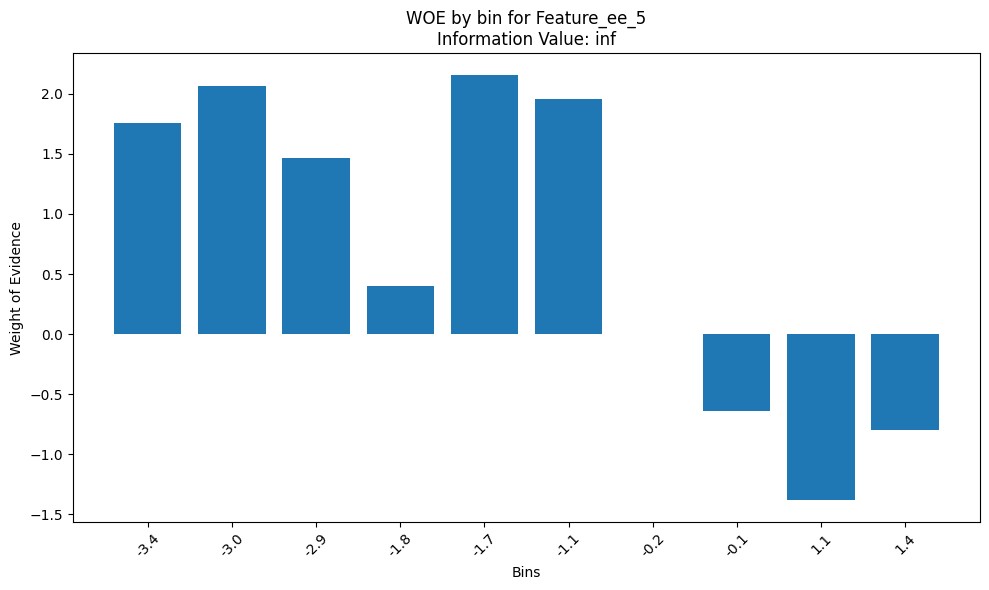


Feature: Feature_ee_5
Information Value: inf

Detailed Statistics:
      total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                
-3.4    901   381    520  0.096971  0.016742  1.756506      0.140924
-3.0    144    72     72  0.018325  0.002318  2.067536      0.033095
-2.9   1421   504    917  0.128277  0.029524  1.469005      0.145069
-1.8   7834  1245   6589  0.316875  0.212138  0.401270      0.042028
-1.7    646   338    308  0.086027  0.009916  2.160482      0.164436
-1.1    535   253    282  0.064393  0.009079  1.959018      0.108361
-0.2      9     0      9  0.000000  0.000290  0.000000           inf
-0.1   3126   195   2931  0.049631  0.094366 -0.642564      0.028745
 1.1   6590   202   6388  0.051413  0.205666 -1.386373      0.213853
 1.4  13783   739  13044  0.188089  0.419961 -0.803250      0.186252




C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


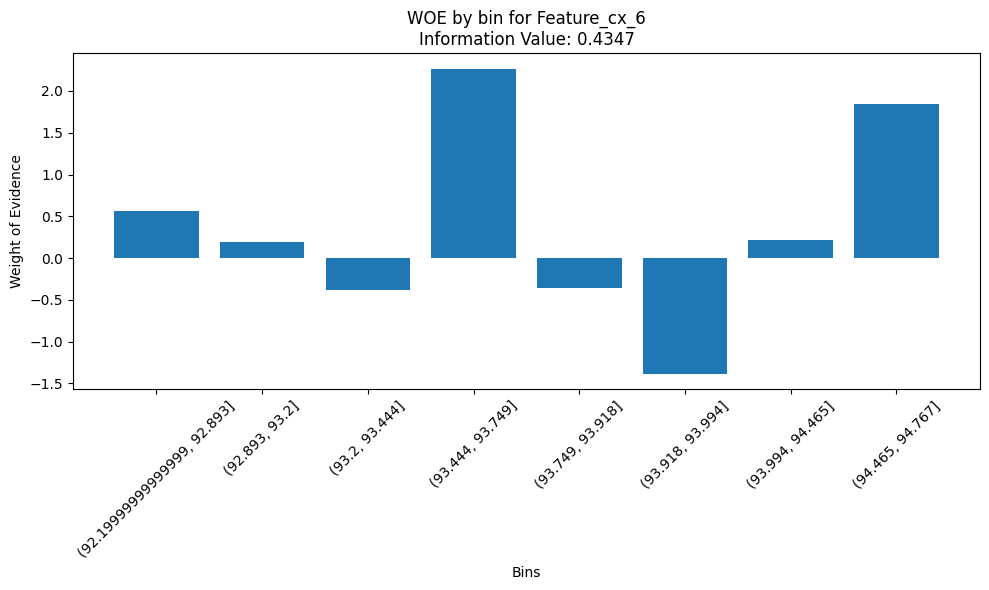


Feature: Feature_cx_6
Information Value: 0.4347

Detailed Statistics:
                             total  good   bad  good_pct   bad_pct       woe  \
bins                                                                           
(92.19999999999999, 92.893]   7043  1284  5759  0.326801  0.185415  0.566752   
(92.893, 93.2]                5777   765  5012  0.194706  0.161365  0.187821   
(93.2, 93.444]                4580   362  4218  0.092135  0.135802 -0.387936   
(93.444, 93.749]               151    83    68  0.021125  0.002189  2.266869   
(93.749, 93.918]              5947   484  5463  0.123187  0.175885 -0.356133   
(93.918, 93.994]              6590   202  6388  0.051413  0.205666 -1.386373   
(93.994, 94.465]              4620   624  3996  0.158819  0.128654  0.210637   
(94.465, 94.767]               281   125   156  0.031815  0.005023  1.845994   

                             iv_component  
bins                                       
(92.19999999999999, 92.893]      0.08013

C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


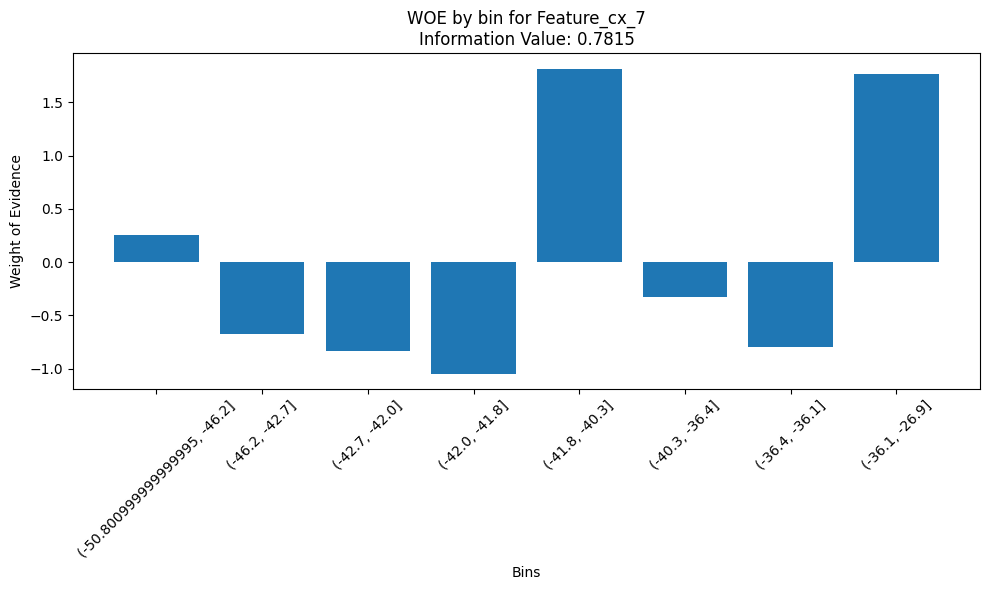


Feature: Feature_cx_7
Information Value: 0.7815

Detailed Statistics:
                              total  good   bad  good_pct   bad_pct       woe  \
bins                                                                            
(-50.800999999999995, -46.2]   7555  1057  6498  0.269025  0.209208  0.251476   
(-46.2, -42.7]                 5718   347  5371  0.088318  0.172923 -0.671909   
(-42.7, -42.0]                 3071   160  2911  0.040723  0.093722 -0.833542   
(-42.0, -41.8]                 3720   158  3562  0.040214  0.114681 -1.047947   
(-41.8, -40.3]                  944   413   531  0.105116  0.017096  1.816221   
(-40.3, -36.4]                 7411   620  6791  0.157801  0.218641 -0.326098   
(-36.4, -36.1]                 4354   234  4120  0.059557  0.132646 -0.800751   
(-36.1, -26.9]                 2216   940  1276  0.239247  0.041082  1.761930   

                              iv_component  
bins                                        
(-50.800999999999995, -46.2]

C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


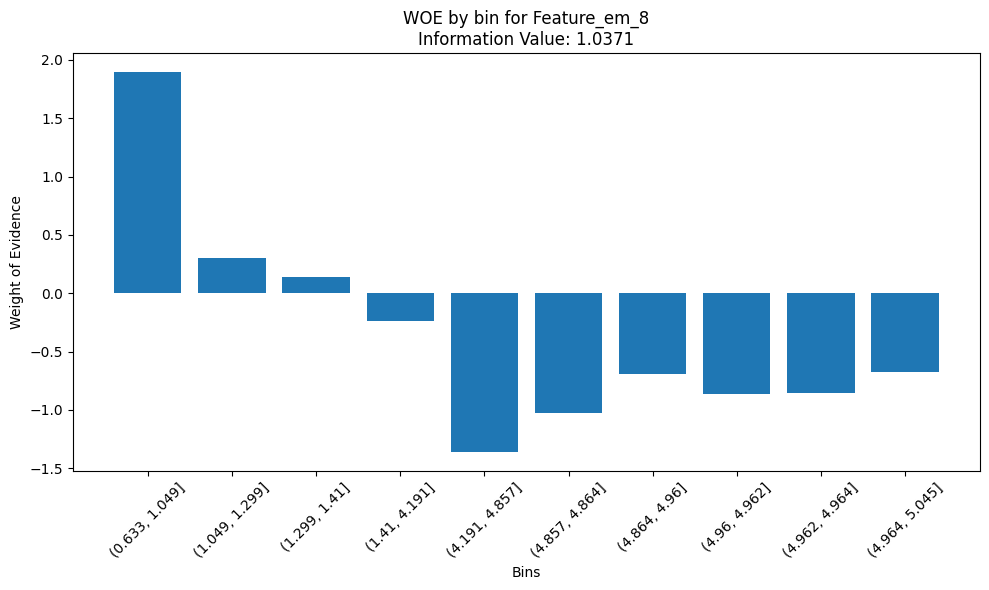


Feature: Feature_em_8
Information Value: 1.0371

Detailed Statistics:
                total  good   bad  good_pct   bad_pct       woe  iv_component
bins                                                                         
(0.633, 1.049]   3509  1602  1907  0.407737  0.061397  1.893257      0.655711
(1.049, 1.299]   3834   561  3273  0.142784  0.105377  0.303795      0.011364
(1.299, 1.41]    3350   424  2926  0.107916  0.094205  0.135878      0.001863
(1.41, 4.191]    3816   345  3471  0.087809  0.111751 -0.241118      0.005773
(4.191, 4.857]   4226   133  4093  0.033851  0.131777 -1.359148      0.133096
(4.857, 4.864]   2944   128  2816  0.032578  0.090663 -1.023507      0.059450
(4.864, 4.96]    3440   205  3235  0.052176  0.104153 -0.691238      0.035929
(4.96, 4.962]    3811   193  3618  0.049122  0.116484 -0.863451      0.058164
(4.962, 4.964]   3085   158  2927  0.040214  0.094237 -0.851602      0.046006
(4.964, 5.045]   2974   180  2794  0.045813  0.089955 -0.674737      0.

C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['total'] = df.groupby('bins')[target].count()
C:\Users\RonaldPatrickPascual\AppData\Local\Temp\ipykernel_20368\4021087953.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary['good'] = df.groupby('bins')[target].sum()


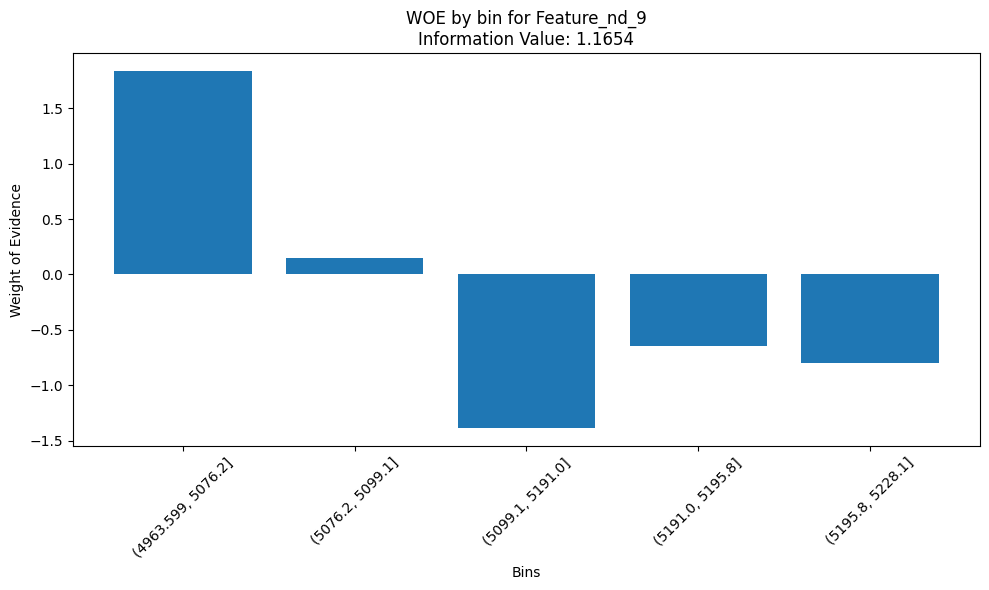


Feature: Feature_nd_9
Information Value: 1.1654

Detailed Statistics:
                    total  good    bad  good_pct   bad_pct       woe  \
bins                                                                   
(4963.599, 5076.2]   4207  1861   2346  0.473657  0.075531  1.835938   
(5076.2, 5099.1]     7274   932   6342  0.237210  0.204185  0.149919   
(5099.1, 5191.0]     6599   202   6397  0.051413  0.205956 -1.387781   
(5191.0, 5195.8]     3126   195   2931  0.049631  0.094366 -0.642564   
(5195.8, 5228.1]    13783   739  13044  0.188089  0.419961 -0.803250   

                    iv_component  
bins                              
(4963.599, 5076.2]      0.730935  
(5076.2, 5099.1]        0.004951  
(5099.1, 5191.0]        0.214473  
(5191.0, 5195.8]        0.028745  
(5195.8, 5228.1]        0.186252  




C:\Users\RonaldPatrickPascual\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


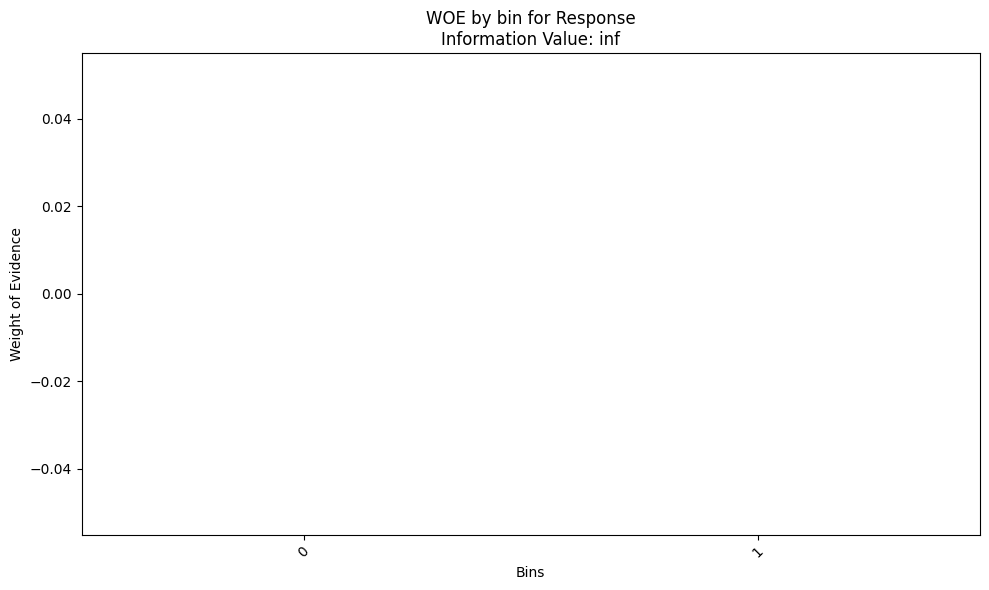


Feature: Response
Information Value: inf

Detailed Statistics:
      total  good    bad  good_pct  bad_pct  woe  iv_component
bins                                                          
0     31060     0  31060       0.0      1.0  0.0           inf
1      3929  3929      0       1.0      0.0  0.0           inf



Analyzing Categorical Features...


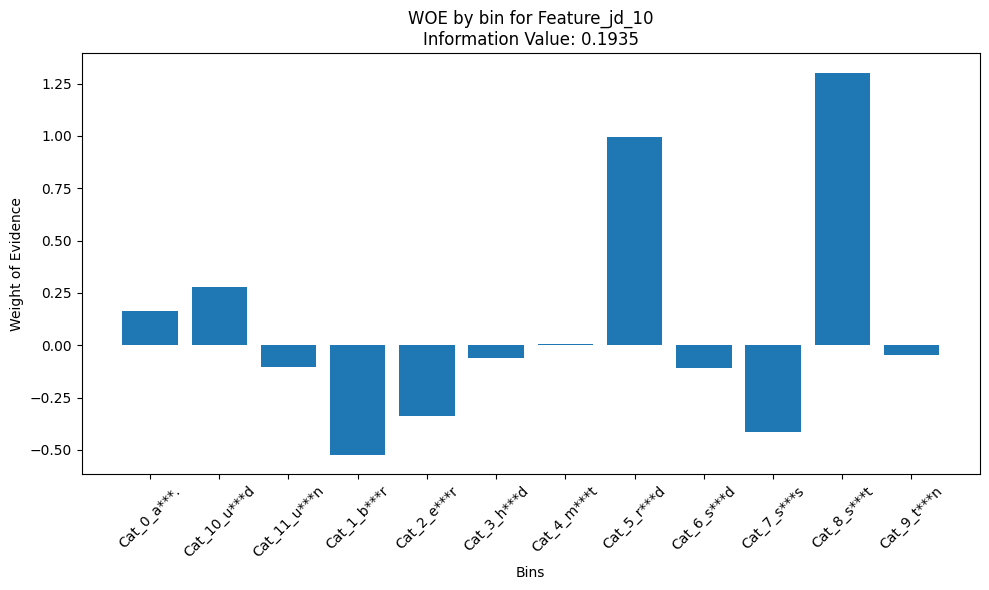


Feature: Feature_jd_10
Information Value: 0.1935

Detailed Statistics:
              total  good   bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_a***.    8864  1148  7716  0.292186  0.248422  0.162261      0.007101
Cat_10_u***d    839   120   719  0.030542  0.023149  0.277166      0.002049
Cat_11_u***n    293    30   263  0.007636  0.008467 -0.103421      0.000086
Cat_1_b***r    7857   547  7310  0.139221  0.235351 -0.525014      0.050469
Cat_2_e***r    1256   104  1152  0.026470  0.037090 -0.337328      0.003582
Cat_3_h***d     901    96   805  0.024434  0.025918 -0.058958      0.000087
Cat_4_m***t    2489   281  2208  0.071519  0.071088  0.006048      0.000003
Cat_5_r***d    1464   373  1091  0.094935  0.035126  0.994264      0.059466
Cat_6_s***d    1215   124  1091  0.031560  0.035126 -0.107033      0.000382
Cat_7_s***s    3351   258  3093  0.065666  0.099581 -0.416401      0.014123
Cat_8_s***t     

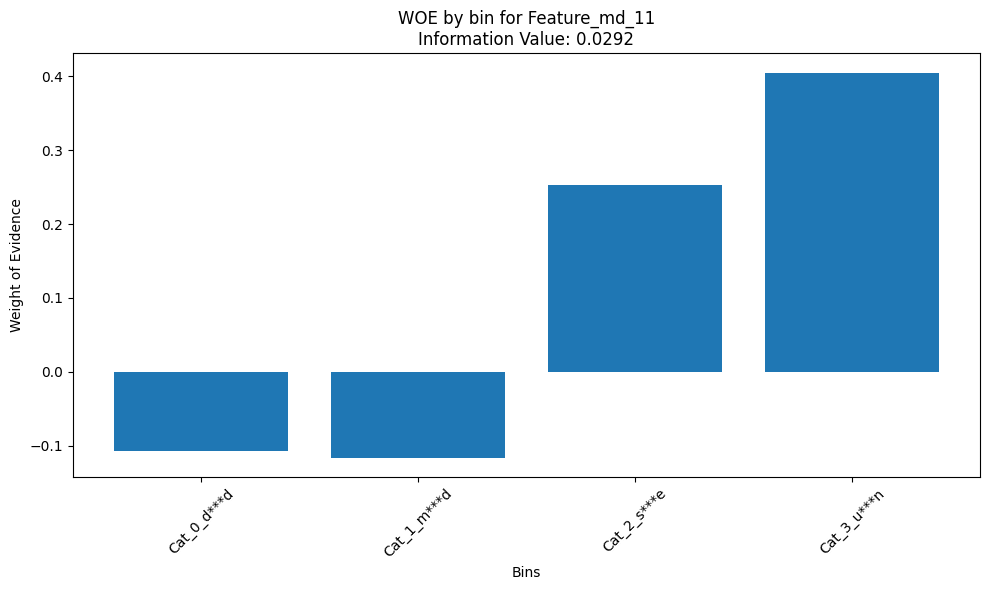


Feature: Feature_md_11
Information Value: 0.0292

Detailed Statistics:
             total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_d***d   3902   398   3504  0.101298  0.112814 -0.107673      0.001240
Cat_1_m***d  21206  2146  19060  0.546195  0.613651 -0.116450      0.007855
Cat_2_s***e   9812  1374   8438  0.349707  0.271668  0.252517      0.019706
Cat_3_u***n     69    11     58  0.002800  0.001867  0.404988      0.000378




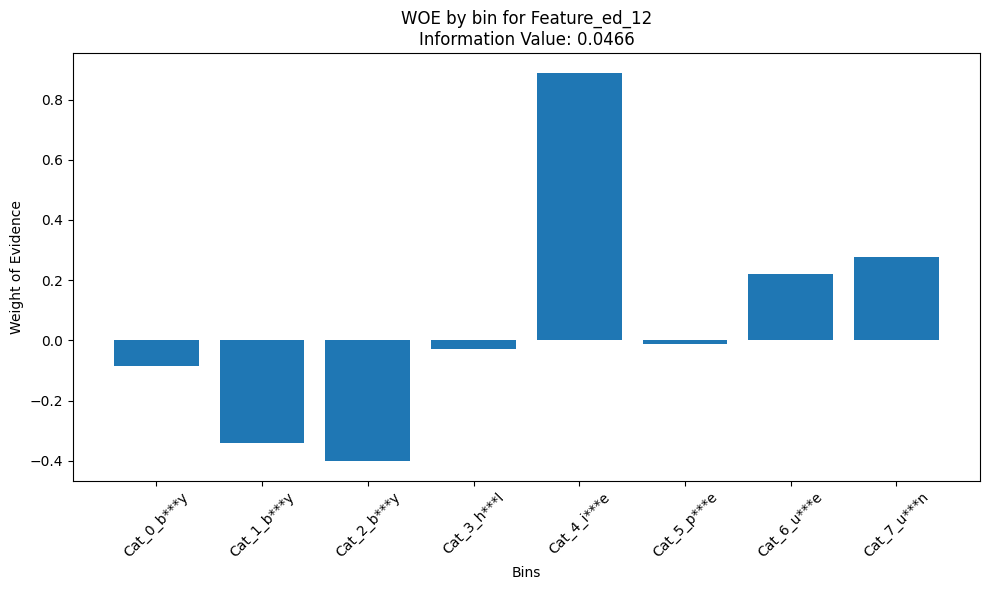


Feature: Feature_ed_12
Information Value: 0.0466

Detailed Statistics:
             total  good   bad  good_pct   bad_pct       woe  iv_component
bins                                                                      
Cat_0_b***y   3533   368  3165  0.093663  0.101900 -0.084290      0.000694
Cat_1_b***y   1962   162  1800  0.041232  0.057952 -0.340410      0.005692
Cat_2_b***y   5176   404  4772  0.102825  0.153638 -0.401570      0.020405
Cat_3_h***l   8039   879  7160  0.223721  0.230522 -0.029944      0.000204
Cat_4_i***e     17     4    13  0.001018  0.000419  0.888881      0.000533
Cat_5_p***e   4477   498  3979  0.126750  0.128107 -0.010650      0.000014
Cat_6_u***e  10309  1403  8906  0.357088  0.286735  0.219423      0.015437
Cat_7_u***n   1476   211  1265  0.053703  0.040728  0.276567      0.003589




C:\Users\RonaldPatrickPascual\AppData\Roaming\Python\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


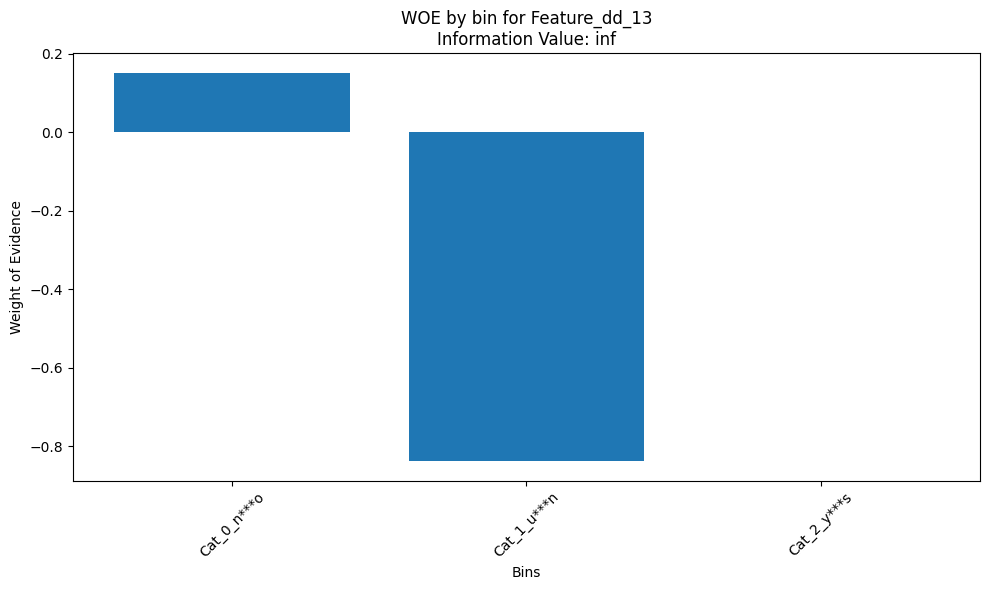


Feature: Feature_dd_13
Information Value: inf

Detailed Statistics:
             total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_n***o  27664  3549  24115  0.903283  0.776401  0.151368      0.019206
Cat_1_u***n   7322   380   6942  0.096717  0.223503 -0.837638      0.106201
Cat_2_y***s      3     0      3  0.000000  0.000097  0.000000           inf




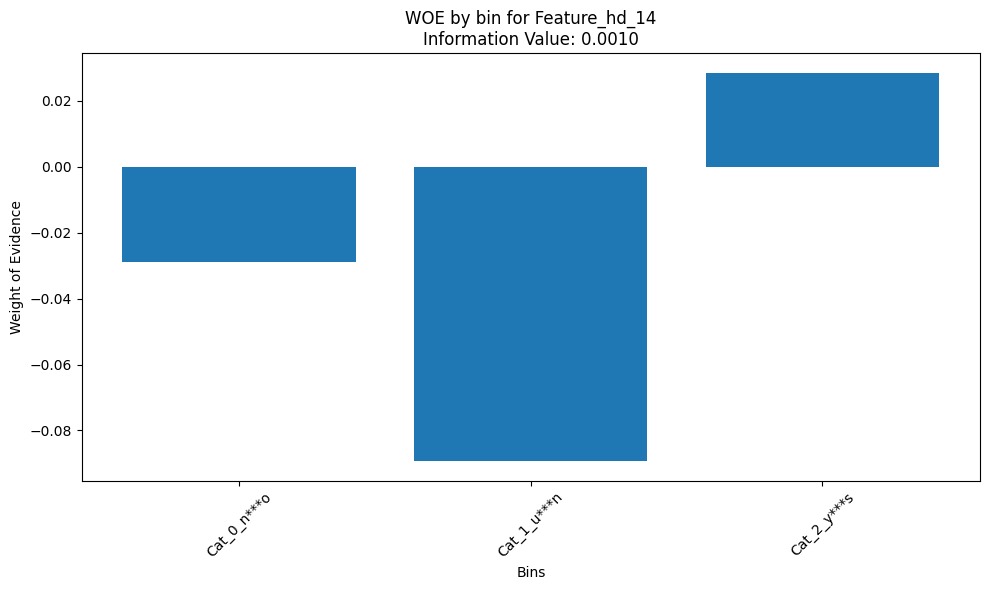


Feature: Feature_hd_14
Information Value: 0.0010

Detailed Statistics:
             total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_n***o  15863  1736  14127  0.441843  0.454829 -0.028968      0.000376
Cat_1_u***n    839    87    752  0.022143  0.024211 -0.089292      0.000185
Cat_2_y***s  18287  2106  16181  0.536014  0.520959  0.028489      0.000429




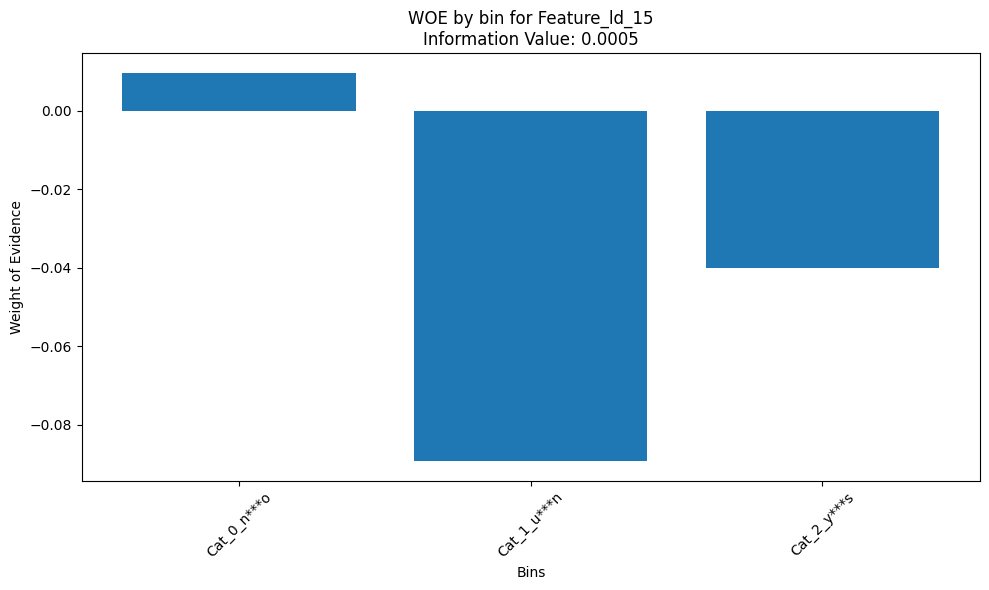


Feature: Feature_ld_15
Information Value: 0.0005

Detailed Statistics:
             total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_n***o  28835  3266  25569  0.831255  0.823213  0.009721      0.000078
Cat_1_u***n    839    87    752  0.022143  0.024211 -0.089292      0.000185
Cat_2_y***s   5315   576   4739  0.146602  0.152576 -0.039938      0.000239




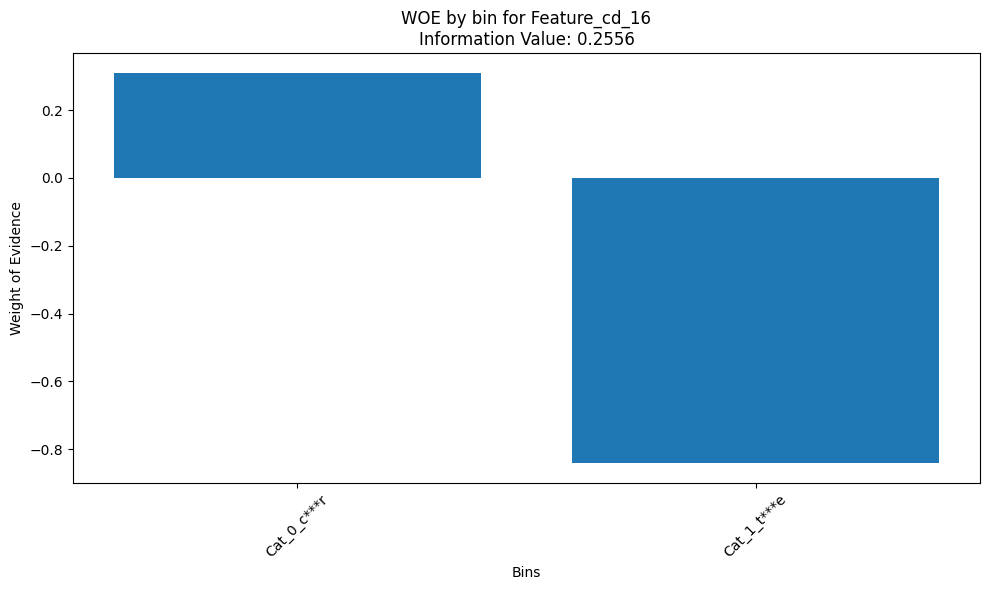


Feature: Feature_cd_16
Information Value: 0.2556

Detailed Statistics:
             total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_c***r  22232  3270  18962  0.832273  0.610496  0.309889      0.068726
Cat_1_t***e  12757   659  12098  0.167727  0.389504 -0.842536      0.186855




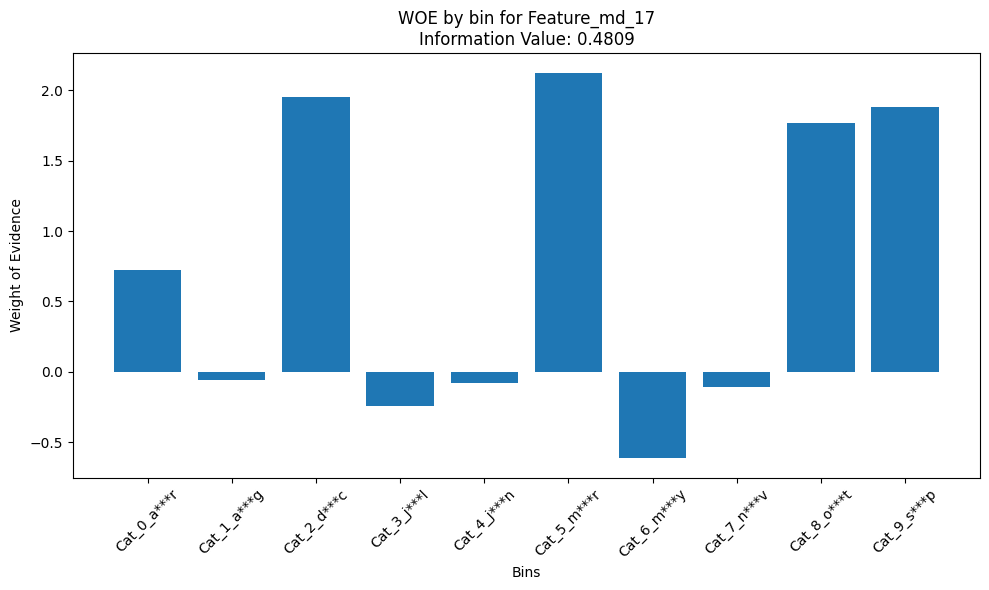


Feature: Feature_md_17
Information Value: 0.4809

Detailed Statistics:
             total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_a***r   2230   460   1770  0.117078  0.056986  0.720028      0.043268
Cat_1_a***g   5191   554   4637  0.141003  0.149292 -0.057122      0.000473
Cat_2_d***c    153    72     81  0.018325  0.002608  1.949753      0.030645
Cat_3_j***l   6120   551   5569  0.140239  0.179298 -0.245700      0.009597
Cat_4_j***n   4539   476   4063  0.121150  0.130811 -0.076723      0.000741
Cat_5_m***r    457   235    222  0.059812  0.007147  2.124444      0.111882
Cat_6_m***y  11737   752  10985  0.191397  0.353670 -0.614014      0.099638
Cat_7_n***v   3482   356   3126  0.090608  0.100644 -0.105043      0.001054
Cat_8_o***t    602   256    346  0.065157  0.011140  1.766275      0.095408
Cat_9_s***p    478   217    261  0.055230  0.008403  1.882913      0.088172




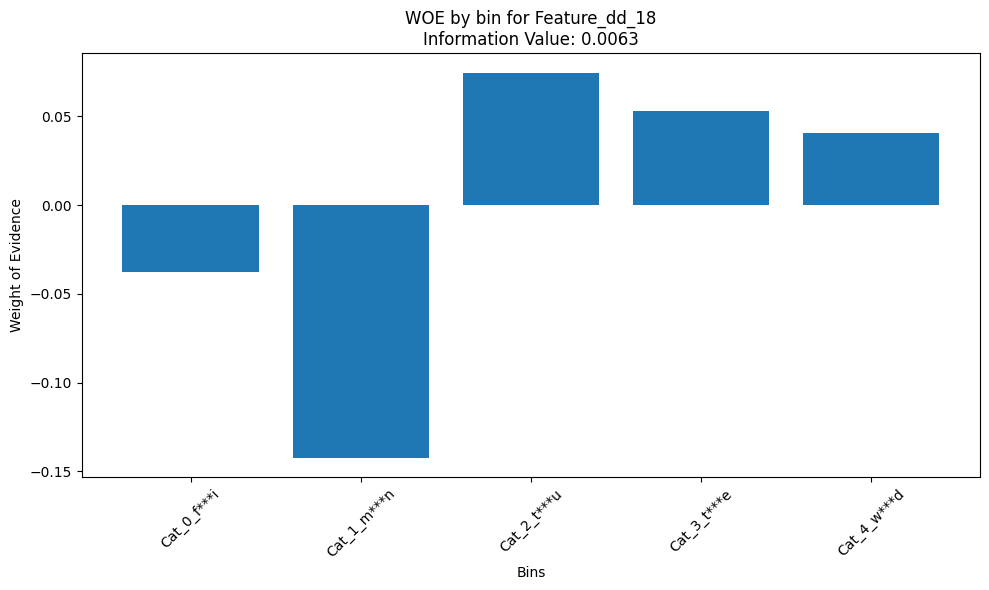


Feature: Feature_dd_18
Information Value: 0.0063

Detailed Statistics:
             total  good   bad  good_pct   bad_pct       woe  iv_component
bins                                                                      
Cat_0_f***i   6612   718  5894  0.182744  0.189762 -0.037685      0.000264
Cat_1_m***n   7243   716  6527  0.182235  0.210142 -0.142487      0.003976
Cat_2_t***u   7353   882  6471  0.224485  0.208339  0.074642      0.001205
Cat_3_t***e   6883   810  6073  0.206159  0.195525  0.052962      0.000563
Cat_4_w***d   6898   803  6095  0.204378  0.196233  0.040667      0.000331




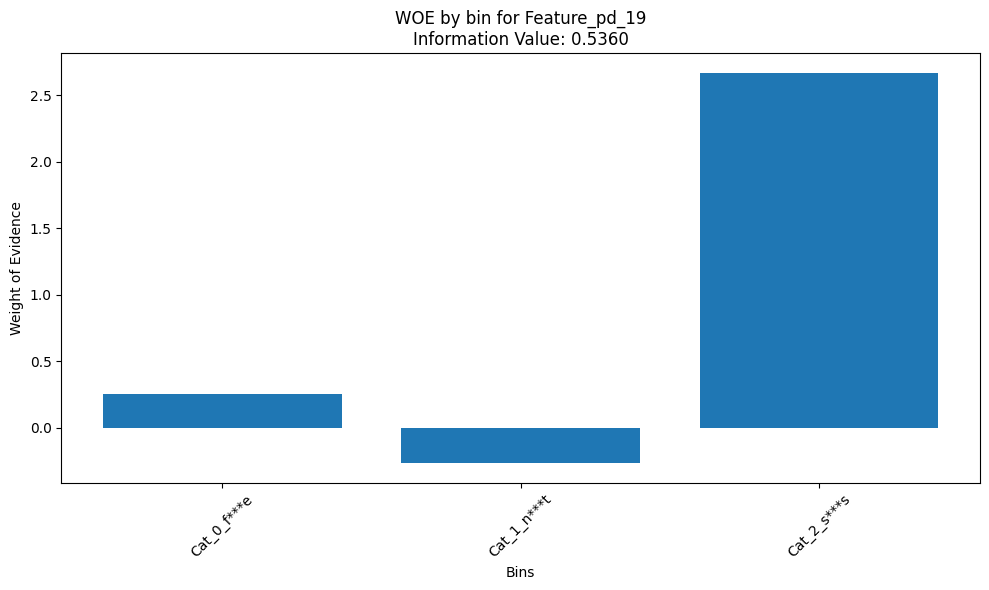


Feature: Feature_pd_19
Information Value: 0.5360

Detailed Statistics:
             total  good    bad  good_pct   bad_pct       woe  iv_component
bins                                                                       
Cat_0_f***e   3646   511   3135  0.130059  0.100934  0.253521      0.007384
Cat_1_n***t  30181  2668  27513  0.679053  0.885802 -0.265794      0.054952
Cat_2_s***s   1162   750    412  0.190888  0.013265  2.666586      0.473649




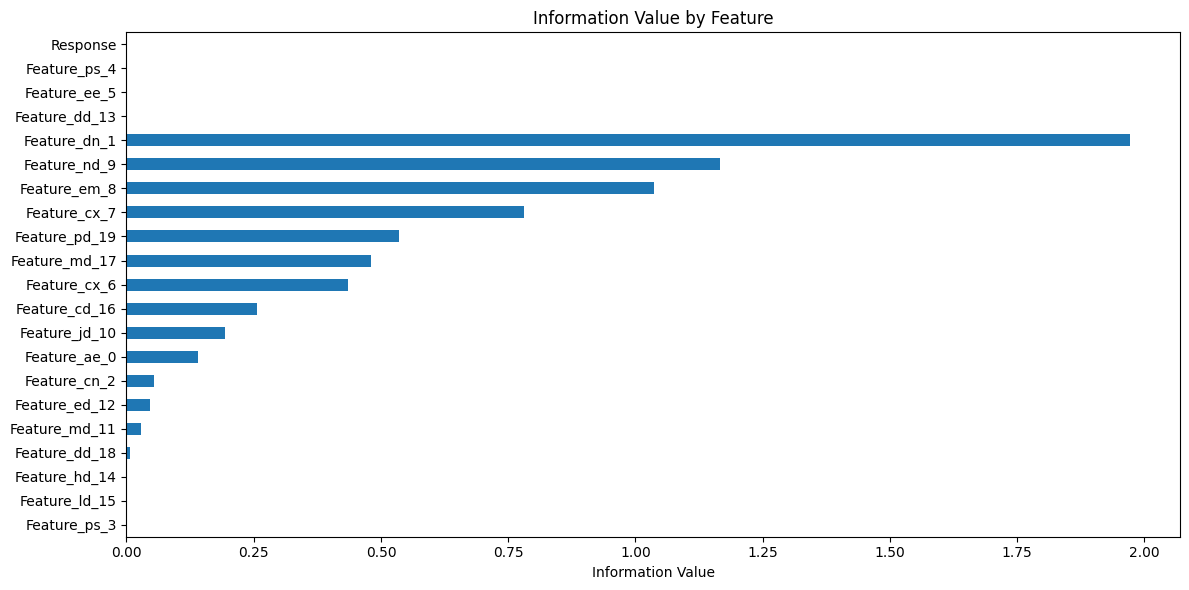


Information Value Summary:
Feature_ps_4: inf - Suspicious predictor
Feature_ee_5: inf - Suspicious predictor
Response: inf - Suspicious predictor
Feature_dd_13: inf - Suspicious predictor
Feature_dn_1: 1.9713 - Suspicious predictor
Feature_nd_9: 1.1654 - Suspicious predictor
Feature_em_8: 1.0371 - Suspicious predictor
Feature_cx_7: 0.7815 - Suspicious predictor
Feature_pd_19: 0.5360 - Suspicious predictor
Feature_md_17: 0.4809 - Strong predictor
Feature_cx_6: 0.4347 - Strong predictor
Feature_cd_16: 0.2556 - Medium predictor
Feature_jd_10: 0.1935 - Medium predictor
Feature_ae_0: 0.1412 - Medium predictor
Feature_cn_2: 0.0550 - Weak predictor
Feature_ed_12: 0.0466 - Weak predictor
Feature_md_11: 0.0292 - Weak predictor
Feature_dd_18: 0.0063 - Not predictive
Feature_hd_14: 0.0010 - Not predictive
Feature_ld_15: 0.0005 - Not predictive
Feature_ps_3: 0.0000 - Not predictive

Feature Selection Recommendations:

Recommended features to keep:
- Feature_ps_4 (IV: inf)
- Feature_ee_5 (IV: inf)

In [17]:
def calculate_woe_iv(df, feature, target='Response', bins=10, show_plots=True):
    """
    Calculate WOE and IV for a feature, handling both numerical and categorical variables.
    
    Parameters:
    -----------
    df : DataFrame
        Input DataFrame
    feature : str
        Feature column name
    target : str
        Target column name (binary)
    bins : int
        Number of bins for numerical variables
    show_plots : bool
        Whether to display WOE plots
    """
    
    df = df.copy()
    
    # Create bins for numerical variables
    if df[feature].dtype in ['int64', 'float64']:
        # Handle special cases where binning might fail
        if df[feature].nunique() <= bins:
            df['bins'] = df[feature]
        else:
            try:
                df['bins'] = pd.qcut(df[feature], q=bins, duplicates='drop')
            except:
                df['bins'] = pd.cut(df[feature], bins=bins)
    else:
        df['bins'] = df[feature]
    
    # Calculate WOE and IV
    summary = pd.DataFrame()
    summary['total'] = df.groupby('bins')[target].count()
    summary['good'] = df.groupby('bins')[target].sum()
    summary['bad'] = summary['total'] - summary['good']
    
    summary['good_pct'] = summary['good'] / summary['good'].sum()
    summary['bad_pct'] = summary['bad'] / summary['bad'].sum()
    
    summary['woe'] = np.log(summary['good_pct'] / summary['bad_pct'])
    summary['iv_component'] = (summary['good_pct'] - summary['bad_pct']) * summary['woe']
    
    iv = summary['iv_component'].sum()
    
    # Replace infinite WOE values
    summary['woe'] = summary['woe'].replace([np.inf, -np.inf], 0)
    
    if show_plots:
        # Create WOE plot
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(summary.index)), summary['woe'])
        plt.title(f'WOE by bin for {feature}\nInformation Value: {iv:.4f}')
        plt.xticks(range(len(summary.index)), summary.index, rotation=45)
        plt.xlabel('Bins')
        plt.ylabel('Weight of Evidence')
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print(f"\nFeature: {feature}")
        print(f"Information Value: {iv:.4f}")
        print("\nDetailed Statistics:")
        print(summary)
        print("\n" + "="*80 + "\n")
    
    return iv, summary

# Calculate IV for all features
def analyze_all_features(df, numerical_features, categorical_features, target='Response'):
    """Run WOE/IV analysis for all features"""
    
    results = {}
    
    # Analyze numerical features
    print("Analyzing Numerical Features...")
    for feature in numerical_features:
        iv, _ = calculate_woe_iv(df, feature, target=target, show_plots=True)
        results[feature] = iv
    
    # Analyze categorical features
    print("\nAnalyzing Categorical Features...")
    for feature in categorical_features:
        iv, _ = calculate_woe_iv(df, feature, target=target, bins=None, show_plots=True)
        results[feature] = iv
    
    # Create summary plot
    plt.figure(figsize=(12, 6))
    iv_df = pd.Series(results).sort_values(ascending=True)
    iv_df.plot(kind='barh')
    plt.title('Information Value by Feature')
    plt.xlabel('Information Value')
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\nInformation Value Summary:")
    for feature, iv in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {iv:.4f} - {interpret_iv(iv)}")
    
    return results

def interpret_iv(iv):
    """Interpret IV values"""
    if iv < 0.02:
        return "Not predictive"
    elif iv < 0.1:
        return "Weak predictor"
    elif iv < 0.3:
        return "Medium predictor"
    elif iv < 0.5:
        return "Strong predictor"
    else:
        return "Suspicious predictor"

# Run the analysis
iv_results = analyze_all_features(df, numerical_features, categorical_features)

# Print feature selection recommendations
print("\nFeature Selection Recommendations:")
print("\nRecommended features to keep:")
for feature, iv in sorted(iv_results.items(), key=lambda x: x[1], reverse=True):
    if iv_results[feature] >= 0.02:  # Usually we keep features with IV > 0.02
        print(f"- {feature} (IV: {iv:.4f})")

print("\nFeatures to consider dropping (not predictive):")
for feature, iv in sorted(iv_results.items(), key=lambda x: x[1], reverse=True):
    if iv_results[feature] < 0.02:
        print(f"- {feature} (IV: {iv:.4f})")

# Additional analysis for highly predictive features
high_iv_features = {k: v for k, v in iv_results.items() if v >= 0.3}
if high_iv_features:
    print("\nDetailed Analysis of Highly Predictive Features:")
    for feature in high_iv_features:
        print(f"\nAnalyzing {feature}...")
        if feature in numerical_features:
            print("Descriptive statistics:")
            print(df[feature].describe())
        else:
            print("Value counts:")
            print(df[feature].value_counts(normalize=True))

## Chi-square test for categorical variables

In [18]:
# 5. Chi-square test of independence with target
chi_square_results = {}
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Response'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[feature] = {
        'chi2': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof
    }

# Sort features by chi-square statistic
chi_square_df = pd.DataFrame.from_dict(chi_square_results, orient='index')
chi_square_df = chi_square_df.sort_values('chi2', ascending=False)

print("\nChi-square test results (relationship with target):")
print(chi_square_df)


Chi-square test results (relationship with target):
                      chi2        p_value  degrees_of_freedom
Feature_pd_19  3514.665460   0.000000e+00                   2
Feature_md_17  2598.452026   0.000000e+00                   9
Feature_jd_10   839.853186  5.227440e-173                  11
Feature_cd_16   739.536143  7.562095e-163                   1
Feature_dd_13   339.313689   2.084340e-74                   2
Feature_ed_12   156.451796   1.789148e-30                   7
Feature_md_11   107.616040   3.575471e-23                   3
Feature_dd_18    21.536021   2.478652e-04                   4
Feature_hd_14     3.432090   1.797757e-01                   2
Feature_ld_15     1.715114   4.241971e-01                   2


## Interpretation of Chi-Square Test Results

### Strong Relationships with Target (p < 0.001)
- Feature_pd_19: Strongest relationship (χ² = 3514.67, p ≈ 0)
  - Very high chi-square value indicates extremely strong dependency
- Feature_md_17: Second strongest (χ² = 2598.45, p ≈ 0) 
  - Strong predictive potential with 9 degrees of freedom
- Feature_jd_10, Feature_cd_16, Feature_dd_13:
  - All show very strong relationships (p < 1e-150)
  - High chi-square values (739-840)

### Moderate Relationships (0.001 < p < 0.05)
- Feature_ed_12, Feature_md_11: Strong evidence of dependency
  - Moderate chi-square values (107-156)
- Feature_dd_18: Weaker but still significant (χ² = 21.54, p < 0.001)

### Weak/No Relationship (p > 0.05)
- Feature_hd_14, Feature_ld_15: No significant relationship
  - High p-values (0.18, 0.42) suggest independence from target

### Key Takeaways
1. Top 5 features show extremely strong relationships with target
2. Clear hierarchy of feature importance based on chi-square values
3. 8 out of 10 features show significant relationships
4. Two features could potentially be dropped due to independence


# Statistical vs Machine Learning Based


Mutual Information Scores - Numerical Features:
Feature_dn_1    0.078718
Feature_em_8    0.074083
Feature_cx_6    0.068395
Feature_cx_7    0.065912
Feature_nd_9    0.062339
Feature_ee_5    0.055105
Feature_ps_3    0.036134
Feature_ps_4    0.020612
Feature_ae_0    0.015153
Feature_cn_2    0.001305

Mutual Information Scores - Categorical Features:
Feature_pd_19_Cat_2_s***s     0.027072
Feature_pd_19_Cat_1_n***t     0.018982
Feature_cd_16_Cat_0_c***r     0.017528
Feature_cd_16_Cat_1_t***e     0.014099
Feature_dd_13_Cat_0_n***o     0.009736
Feature_md_17_Cat_6_m***y     0.008725
Feature_hd_14_Cat_2_y***s     0.005593
Feature_md_17_Cat_5_m***r     0.005295
Feature_jd_10_Cat_5_r***d     0.005123
Feature_md_17_Cat_8_o***t     0.004846
Feature_jd_10_Cat_8_s***t     0.004521
Feature_dd_13_Cat_1_u***n     0.004486
Feature_ld_15_Cat_0_n***o     0.004028
Feature_md_11_Cat_1_m***d     0.003935
Feature_jd_10_Cat_1_b***r     0.003672
Feature_md_17_Cat_2_d***c     0.003099
Feature_md_17_Cat_9_s***p 

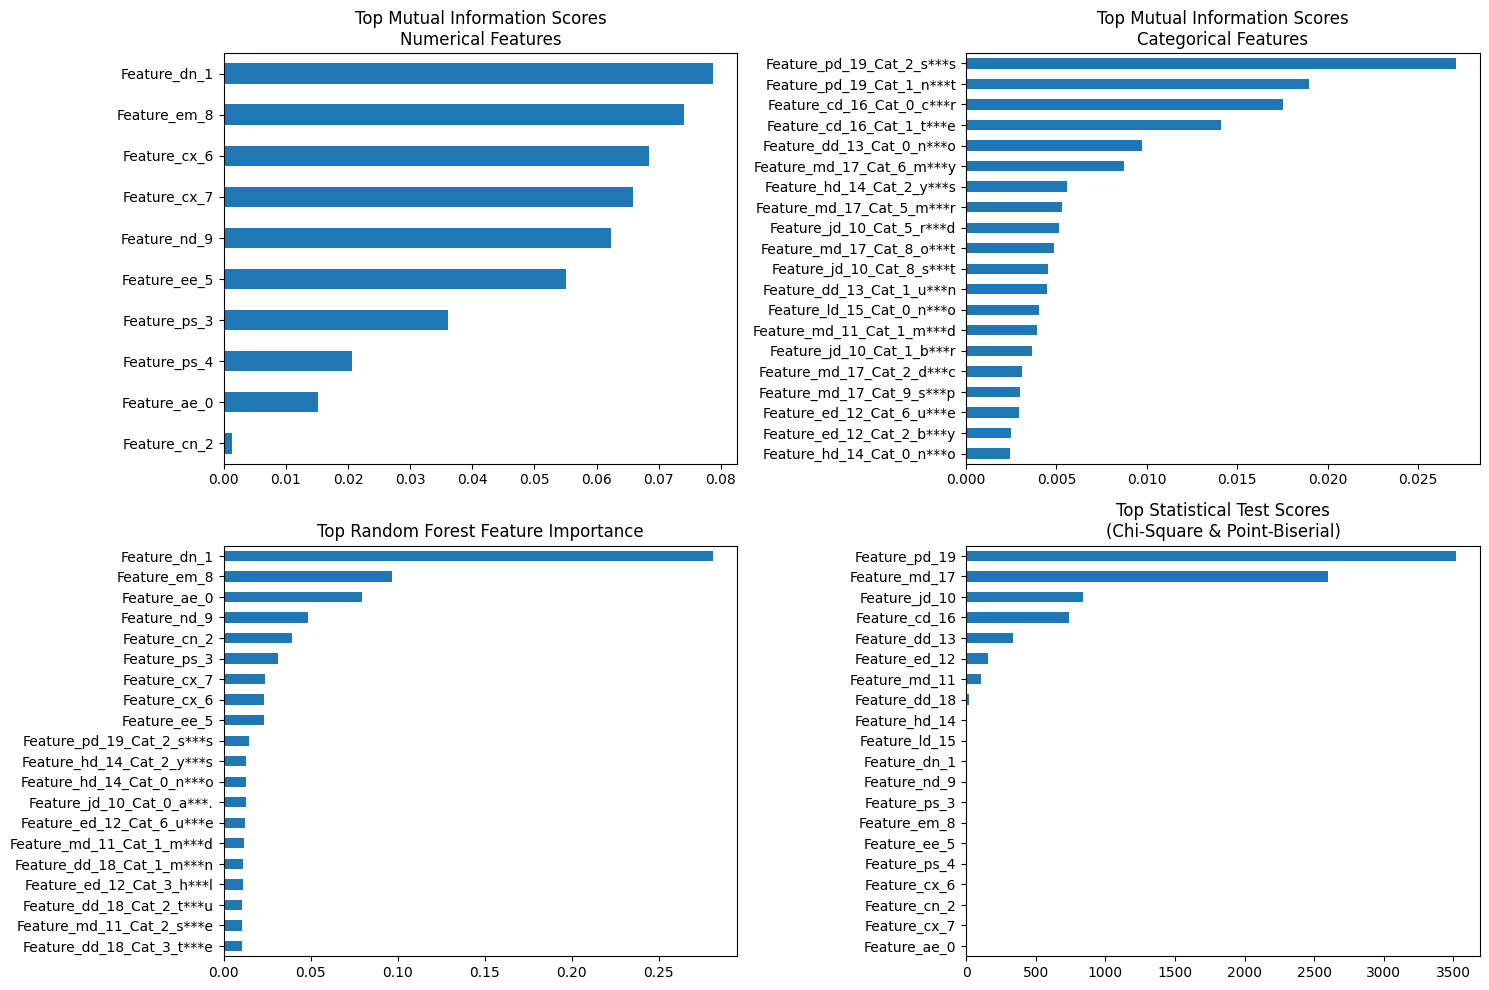

In [24]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency, pointbiserialr

def analyze_feature_importance(df, numerical_features, categorical_features, target='Response'):
    """Comprehensive feature importance analysis"""
    
    results = {}
    
    # Convert numerical features dict to list
    numerical_features_list = list(numerical_features.keys())
    
    # Separate numerical and categorical features
    X_num = df[numerical_features_list]
    X_cat = df[categorical_features]
    y = df[target]
    
    # Mutual Information for numerical features
    mi_scores_num = mutual_info_classif(X_num, y)
    results['mutual_info_num'] = dict(zip(numerical_features_list, mi_scores_num))
    
    # Mutual Information for categorical features (one-hot encoded)
    X_cat_encoded = pd.get_dummies(X_cat)
    mi_scores_cat = mutual_info_classif(X_cat_encoded, y)
    results['mutual_info_cat'] = dict(zip(X_cat_encoded.columns, mi_scores_cat))
    
    # Random Forest importance
    X = pd.concat([X_num, X_cat_encoded], axis=1)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    results['rf_importance'] = dict(zip(X.columns, rf.feature_importances_))
    
    # Statistical tests
    statistical_scores = {}
    
    # Point-biserial correlation for numerical features
    for col in numerical_features_list:
        correlation, p_value = pointbiserialr(df[col], y)
        statistical_scores[col] = {
            'method': 'pointbiserial', 
            'score': abs(correlation), 
            'p_value': p_value
        }
    
    # Chi-square test for categorical features  
    for col in categorical_features:
        contingency_table = pd.crosstab(df[col], y)
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        statistical_scores[col] = {
            'method': 'chi2',
            'score': chi2,
            'p_value': p_value
        }
    
    results['statistical_tests'] = statistical_scores
    
    return results

# Run analysis for both datasets
importance_results_eda = analyze_feature_importance(
    pd.read_csv('dataset.csv', sep='|'),
    numerical_features={
        'Feature_ae_0': 'Age',
        'Feature_dn_1': 'Call Duration', 
        'Feature_cn_2': 'Call Attempts',
        'Feature_ps_3': 'Days Since Last Campaign',
        'Feature_ps_4': 'Previous Campaign Calls',
        'Feature_ee_5': 'Employment Rate',
        'Feature_cx_6': 'Consumer Price Index',
        'Feature_cx_7': 'Consumer Confidence',
        'Feature_em_8': 'Interest Rate',
        'Feature_nd_9': 'Number of Employees'
    },
    categorical_features=[f'Feature_{x}' for x in ['jd_10','md_11','ed_12','dd_13','hd_14','ld_15','cd_16','md_17','dd_18','pd_19']]
)

# Print all scores
print("\nMutual Information Scores - Numerical Features:")
mi_scores_num = pd.Series(importance_results_eda['mutual_info_num']).sort_values(ascending=False)
print(mi_scores_num.to_string())

print("\nMutual Information Scores - Categorical Features:")
mi_scores_cat = pd.Series(importance_results_eda['mutual_info_cat']).sort_values(ascending=False)
print(mi_scores_cat.to_string())

print("\nRandom Forest Feature Importance:")
rf_scores = pd.Series(importance_results_eda['rf_importance']).sort_values(ascending=False)
print(rf_scores.to_string())

print("\nStatistical Test Scores:")
print("\npointbiserial:")
print(f"{'Feature':<15} {'Score':<10} {'P-value':<10}")
print("-" * 35)
for feature, results in sorted(importance_results_eda['statistical_tests'].items()):
    if results['method'] == 'pointbiserial':
        print(f"{feature:<15} {results['score']:<10.4f} {results['p_value']:.2e}")

print("\nchi2:")
print(f"{'Feature':<15} {'Score':<10} {'P-value':<10}")
print("-" * 35)
for feature, results in sorted(importance_results_eda['statistical_tests'].items()):
    if results['method'] == 'chi2':
        print(f"{feature:<15} {results['score']:<10.4f} {results['p_value']:.2e}")

# Plotting
plt.figure(figsize=(15, 10))

# Helper function to get top N features
def plot_top_n(data, ax, title, n=20):
    data_sorted = data.sort_values(ascending=True)  # Sort ascending for horizontal bars
    if len(data_sorted) > n:
        data_sorted = data_sorted[-n:]  # Get top N
    data_sorted.plot(kind='barh', ax=ax)
    ax.set_title(title)

# Plot 1: Mutual Information - Numerical Features
plt.subplot(221)
plot_top_n(mi_scores_num, plt.gca(), 'Top Mutual Information Scores\nNumerical Features')

# Plot 2: Mutual Information - Categorical Features
plt.subplot(222)
plot_top_n(mi_scores_cat, plt.gca(), 'Top Mutual Information Scores\nCategorical Features')

# Plot 3: Random Forest Feature Importance
plt.subplot(223)
plot_top_n(rf_scores, plt.gca(), 'Top Random Forest Feature Importance')

# Plot 4: Statistical Test Scores
plt.subplot(224)
stat_scores = pd.Series({k: v['score'] for k,v in importance_results_eda['statistical_tests'].items()})
plot_top_n(stat_scores, plt.gca(), 'Top Statistical Test Scores\n(Chi-Square & Point-Biserial)')

plt.tight_layout()
plt.show()

# Feature Importance Analysis

## Summary Table

| Importance Level | Feature | Key Metrics | Notes |
|-----------------|---------|-------------|--------|
| **High** | Feature_dn_1 (Call Duration) | • MI: 0.079 (highest)<br>• RF: 0.281 (highest)<br>• Pointbiserial: 0.409<br>• IV: 1.971 (suspicious) | Critical predictor across all metrics |
| **High** | Feature_em_8 (Interest Rate) | • MI: 0.074<br>• RF: 0.097 (2nd highest)<br>• Strong statistical significance<br>• IV: 1.037 (suspicious) | Consistent performance across metrics |
| **High** | Feature_pd_19 (Previous Campaign Outcome) | • Chi-square: 3514.89 (highest)<br>• Strong categorical MI<br>• Extremely low p-value<br>• IV: 0.536 (suspicious) | Best categorical predictor |
| **High** | Feature_md_17 (Month Contacted) | • Chi-square: 2596.58 (2nd highest)<br>• Good categorical MI<br>• IV: 0.481 (strong) | Shows strong seasonal patterns |
| **Medium** | Feature_cx_6/7 (Price/Confidence Indices) | • MI: 0.068/0.066<br>• Moderate RF importance<br>• IV: 0.435/0.782 (strong/suspicious) | Complementary economic indicators |
| **Medium** | Feature_nd_9 (Number of Employees) | • MI: 0.062<br>• RF: 0.048<br>• IV: 1.165 (suspicious) | Strong statistical significance |
| **Medium** | Feature_ee_5 (Employment Rate) | • MI: 0.055<br>• IV: inf (suspicious) | Relevant economic indicator |
| **Medium** | Feature_cd_16 (Contact Medium) | • Chi-square: 739.85<br>• Moderate categorical MI<br>• IV: 0.256 (medium) | Important for campaign execution |
| **Low** | Feature_ae_0 (Age) | • MI: 0.015<br>• Weak pointbiserial<br>• IV: 0.141 (medium) | Only moderately significant |
| **Low** | Feature_cn_2 (Call Attempts) | • MI: 0.001 (lowest)<br>• Low across metrics<br>• IV: 0.055 (weak) | Possibly redundant |
| **Low** | Feature_ps_3/4 (Previous Campaign Metrics) | • Moderate to low MI<br>• Low RF importance<br>• IV: 0.000/inf (not predictive/suspicious) | May be redundant with Feature_pd_19 |
| **Very Low** | Feature_hd_14 (Home Loan) | • Non-significant chi-square (p=0.184)<br>• Very low MI<br>• IV: 0.001 (not predictive) | No clear predictive value |
| **Very Low** | Feature_ld_15 (Personal Loan) | • Non-significant chi-square (p=0.425)<br>• Very low MI<br>• IV: 0.001 (not predictive) | No clear predictive value |
| **Very Low** | Remaining Categorical Features (14-20) | • Very low MI scores (≈0.000)<br>• Low RF importance<br>• IV: mostly not predictive | Consider only strongest categories |

## Recommendations

1. Focus on top 8 features (High and Medium importance)
2. Drop or combine low importance features  
3. Consider feature engineering for related weak predictors
4. Remove zero-importance categorical encodings
5. Retain only strongest categories for categorical variables
6. Review features with suspicious IV scores (>1 or inf) for potential data issues